# COMS6998 Final Report
Liushiya Chen $\quad$ Peimou Sun

In [2]:
PACKAGE_PATH = "F:\PSun-dev\Python\mlpp_project" # change the package path
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import sys
import time
sys.path.append(PACKAGE_PATH)

import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import torch
from pyro.optim import ClippedAdam
import pyro.distributions as dist

from ldavi.bbvi import LDABBVI
from ldavi.cavi import LDACAVI
from util import load_process, run_mc_experiment,cavi_topic_criticism

## 1. Problem statement and data description

### 1.1 Problem statement

The goal of this project is to justify if BBVI can be a good alternative to the more model-specific CAVI. The hypothesis is that, like text document, each order can be explained by a set of "topics". For example, a shopping cart with the following products: \{baby food, diapers, plant-based meat, soy milk\} might be explained by the "Baby" and "Veganism" topics. 

### 1.2 Data description

We are using Instacart order data. The data set consists of a set of orders, and each order is a set of products. For each product, we know its name, department, and aisle number. The data include 49,688 types of products and 1,384,617 records of purchased products.

**Data Preprocessing:**

The product names are lightly preprocessed to reduce the number of unique items:

1) Only the last two words of each product name is kept. This gives us a good idea of what most items are and drops detailed descriptions.

2) We used a manually created list of "stopwords" to remove words that are not descriptive (e.g. "oz", "gallon", "ct", "lb")

Examples: "Mexican Big Green Organic Avocados" to "Organic Avocados" and "1 Gallon Milk" to "Milk"

In [3]:
order, data, vocab = load_process(nrows=200)
data_series = pd.Series(data)
pd.set_option('display.max_colwidth', 60)
pd.DataFrame(data_series.rename('products')).head(5)

,products
0,"[spring water, calcium vitamin, bean yogurt, organic ban..."
1,"[salad dressing, seedless grapes, organic bananas, chopp..."
2,"[irish butter, almond milk, breakfast sausage, sunday ba..."
3,"[organic strawberries, genoa salami, baby carrots, corn ..."
4,"[banana, vanilla yogurt, honeycrisp apple, baby spinach,..."


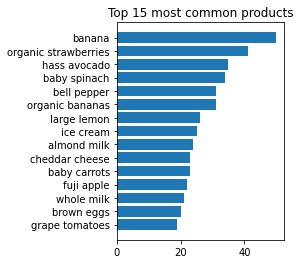

In [4]:
prod = pd.Series('|'.join(data_series.apply('|'.join)).split('|'))
prod_count = prod.value_counts().head(15).iloc[::-1]
plt.figure(figsize=(3, 4))
plt.barh(prod_count.index, prod_count)
plt.title('Top 15 most common products')
plt.show()

In this project, the 90% of data work as the training set, and the rest works as validation set. 

In [5]:
# process the validation data
corpora = list(vocab)
split_ = int(0.9 * len(data))
train_data = data[:split_]
valid_data = data[split_:]

## 2. LDA model

The orders are represented as random mixtures over latent topics, where each topic is characterized by a distribution over products.

$K$ = number of topics, $\quad$ $O$ = number of orders, 

$V$ = total number of unique products, $\quad$ $N_i$ = number of products in order $i$,

**Prior parameters:** $\alpha, \beta: \alpha_i>0, \beta_i\in[0,1]^V, \sum_j\beta_{i,j}=1$, where $i = 1\dots K$


**Data generation process:**

1. For each order $i$: $\theta_i\sim$ $Dir(\alpha$), where $\theta_i \in [0,1]^K, \sum_j\theta_{i,j}=1$.

2. For each product $j\in[1..N_i]$ in order $i$: 

$\quad$ 2a. pick topic $z_{i,j}\sim$ Categorical($\theta_i$) 

$\quad$ 2b. pick product $p_{i,j}\sim$ Categorical($\beta_{z_{i,j}}$)


**Joint distribution:**

$$\mathbb{P}(\mathbf{P}, \mathbf{Z},\boldsymbol{\theta};\alpha,\beta) = \prod\limits^O_{i=1} \Pr(\theta_i;\alpha)\prod\limits^{N_i}_{j=1} \Pr(z_{i,j}|\theta_j)\Pr(\mathbf{P}_{i,j}|\beta_{z_{i, j}})$$ 


We will test different topics numbers in the model criticism part. In the inference part, we will only show the inference result of model with 5 topics. 

## 3. Inference

The task in inference part is to find the posterior distribution for latent variables $(\theta, \mathbf{Z})$.

$$p(\boldsymbol{\theta}, \mathbf{Z}| \mathbf{P}, \alpha, \beta) = \prod\limits_{i = 1}^{O}\frac{p(\theta_i, \mathbf{z_i}, \mathbf{p_i}| \alpha, \beta)}{p(\mathbf{p_i} | \alpha, \beta)}$$

, where $\mathbf{z}_i$ denotes the topics vector and $\mathbf{p}_i$ denotes the products vector for the $i$th order. Based on the mean-field assumption, we will use BBVI and CAVI to approximate the posterior distribution and further compare the result of two inference algorithm. 

We calculate the ELBO and predictive probability here to show the optimization. We are using MC integral to calculate the predictive probability(with 10 particles). The general equation of predictive probability can be written as:

$$p(w) = \int_{z,\theta} p(w, z, \theta) dzd\theta = \int_{z,\theta} p(w| z, \theta) p(z, \theta)dzd\theta \approx \frac{1}{S}\sum_{i=1}^S p(w | z_i, \theta_i)$$

Note that we should sample the latent varibales from the posterior distribution to calculate the predictive probability, i.e.
$$p(w) = \int_{z,\theta} p(w, z, \theta) dzd\theta = \int_{z,\theta} p(w| z, \theta) q(z, \theta | \phi, \gamma)dzd\theta \approx \frac{1}{S}\sum_{i=1}^S p(w | z_i, \theta_i)$$

The predictive probability will be the metric in the criticism section. 

This CAVI algorithm here is not a probabilistic programming method. However, it has been proved as a reliable inference method  for topic model and it can show us the possible best inference result. Therefore, it is very helpful to show us the potential shortcomings of the BBVI. 

### 3.1 BBVI

In [5]:
n_topics = 5
opt_params = {"lr": 0.005, "betas": (0.95, 0.999)}
n_steps = 1000 # must be more than 20 steps
n_particles = 1

st = time.time()
bbvi_obj = LDABBVI(train_data, list(vocab), 
                   valid_data, ClippedAdam, opt_params,
                   n_topics)
e_eblo, log_prob, valid_prob = bbvi_obj.run_svi(
    n_steps=n_steps, num_particles=n_particles)
print(f"Takes {time.time() - st} seconds")

0% (65321.0) (-24348.9) (-2500.5) | 5% (64476.6) (-24535.5) (-2447.3) | 10% (63680.5) (-24194.1) (-2466.7) | 15% (63387.3) (-24072.6) (-2427.4) | 20% (62922.7) (-23808.1) (-2446.3) | 25% (63846.2) (-23613.0) (-2425.0) | 30% (62456.1) (-23575.9) (-2396.0) | 35% (62197.0) (-23619.7) (-2380.4) | 40% (61574.4) (-23460.0) (-2391.9) | 45% (61646.6) (-23268.4) (-2377.2) | 50% (62030.8) (-23348.6) (-2449.1) | 55% (61291.0) (-23098.3) (-2441.0) | 60% (60891.4) (-23104.6) (-2391.7) | 65% (60886.8) (-23210.1) (-2396.1) | 70% (61264.0) (-23255.4) (-2393.5) | 75% (61157.2) (-22978.4) (-2388.9) | 80% (61188.4) (-23063.0) (-2368.2) | 85% (60754.8) (-23111.4) (-2333.9) | 90% (60973.9) (-22908.9) (-2404.3) | 95% (60874.7) (-23017.9) (-2363.2) | Takes 5917.793165922165 seconds


(1.0, 1000.0)

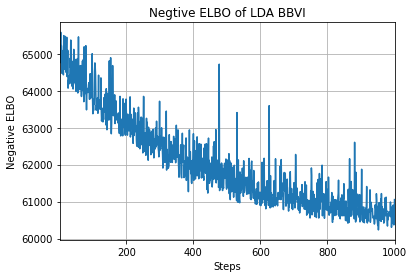

In [6]:
plt.plot(np.linspace(1, len(e_eblo), len(e_eblo)), e_eblo)
plt.title("Negtive ELBO of LDA BBVI")
plt.xlabel("Steps")
plt.ylabel("Negative ELBO")
plt.grid()
plt.xlim((1, len(e_eblo)))

(1.0, 1000.0)

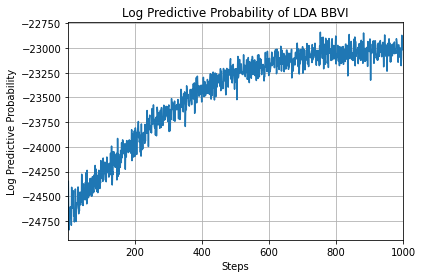

In [7]:
plt.plot(np.linspace(1, len(log_prob),
                     len(log_prob)), log_prob)
plt.title("Log Predictive Probability of LDA BBVI")
plt.xlabel("Steps")
plt.ylabel("Log Predictive Probability")
plt.grid()
plt.xlim((1, len(log_prob)))

(1.0, 1000.0)

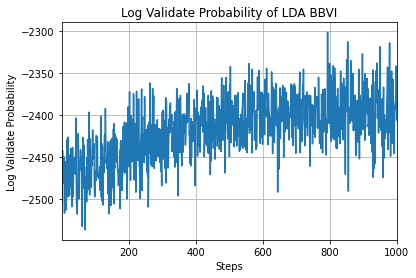

In [8]:
plt.plot(np.linspace(1, len(valid_prob), 
                     len(valid_prob)), valid_prob)
plt.title("Log Validate Probability of LDA BBVI")
plt.xlabel("Steps")
plt.ylabel("Log Validate Probability")
plt.grid()
plt.xlim((1, len(valid_prob)))

### 3.2 CAVI

In the CAVI algorithm, we approximate the posterior distribution in the order level with distribution(guide) $q(\theta, \mathbf{z} | \gamma, \phi)$, where $\gamma$ is a $(K, 1)$ vector and $\phi$ is a $(N_i, K)$ matrix. We further use EM algorithm to estimate the $\alpha$ and $\beta$. The iterative algorithm can be concluded as:

1) (E-step) Find the optimal $\gamma^{*}_i$ and $\phi^{*}_i$ in each document.

2) (M-step) Maximize the lower bound of likelihood $\mathcal{l}(\alpha, \beta) = \sum_{d=1}^{M} \log{p}(\mathbf{w}_d | \alpha, \beta)$ based on the parameters we got in the E-step.

The detailed derivation can be found in reference 1. 

In [9]:
# model settings
num_topics = 5

# initialize the parameters
alpha = torch.rand(size=(num_topics, )) * 10
beta = torch.rand(size=(len(alpha), len(vocab))) 
beta /= beta.sum(-1).view(-1, 1)

# instantialize the cavi_obj
cavi_obj = LDACAVI(alpha, beta, 
                   corpora, num_topics,
                   num_particles=1)

In [ ]:
cavi_obj.reset_graph()

# Parameter estimation
alpha, beta = cavi_obj.estimate_params(
    train_data, tol=2e-3, show_step=50)

Step 50 | beta diff norm=0.0218 | alpha diff norm=0.1501 | ELBO=-19268.782


Compared to the ELBO of BBVI, the ELBO increase monotonously in CAVI algorithm.

(1.0, 60.0)

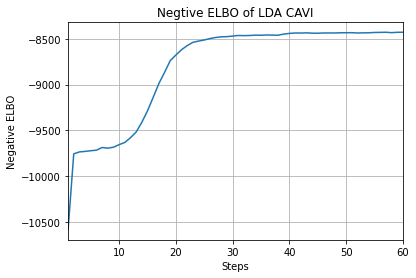

In [7]:
plt.plot(np.linspace(1, len(cavi_obj.trace_elbo), 
                     len(cavi_obj.trace_elbo)),
         cavi_obj.trace_elbo)
plt.title("Negtive ELBO of LDA CAVI")
plt.xlabel("Steps")
plt.ylabel("Negative ELBO")
plt.grid()
plt.xlim((1, len(cavi_obj.trace_elbo)))

## 4. Criticism

### 4.1 Model criticism

In this section, we compare the influence of the number of topics in LDA model given en effective enough inference algorithm. The number of topics can also be treated as the different prior distribution of alpha and beta. The metric of the model is the predictive probability in the validation set. Due to the long training time, we only showed the result of 2 topics here. 

In [ ]:
n_topics = 2
opt_params = {"lr": 0.005, "betas": (0.95, 0.999)}
n_steps = 1000 # must be more than 20 steps
n_particles = 1

st = time.time()
bbvi_obj = LDABBVI(train_data, list(vocab), 
                   valid_data, ClippedAdam, opt_params,
                   n_topics)
e_eblo, log_prob, valid_prob = bbvi_obj.run_svi(
    n_steps=n_steps, num_particles=n_particles)
print(f"Takes {time.time() - st} seconds")

In [ ]:
plt.plot(np.linspace(1, len(log_prob),
                     len(log_prob)), log_prob)
plt.title("Log Predictive Probability of LDA BBVI")
plt.xlabel("Steps")
plt.ylabel("Log Predictive Probability")
plt.grid()
plt.xlim((1, len(log_prob)))

In [ ]:
plt.plot(np.linspace(1, len(valid_prob), 
                     len(valid_prob)), valid_prob)
plt.title("Log Validate Probability of LDA BBVI")
plt.xlabel("Steps")
plt.ylabel("Log Validate Probability")
plt.grid()
plt.xlim((1, len(valid_prob)))

### 4.2 Inference criticism

The reasons for the failures of BBVI can be concluded as:

**a) Monte Carlo Integration Variance**

When computing the ELBO gradient at each step, we are trying to estimate a quantity of the following form:

$$\nabla_{\phi}\mathbb{E}_{q_{\phi}({\bf z})} \left [f_{\phi}({\bf z}) \right]$$

Before we can move the $\nabla$ into the expectation, we need to remove the dependency of $q(z)$ on $\phi$. This can be done by reparametrization, which is easy for LDA because the PDF of dirichlet and categorical are continuous w.r.t. their parameters.

$$\nabla_{\phi}\mathbb{E}_{q({\bf \epsilon})} \left [f_{\phi}(g_{\phi}({\bf \epsilon})) \right]=
\mathbb{E}_{q({\bf \epsilon})} \left [\nabla_{\phi}f_{\phi}(g_{\phi}({\bf \epsilon})) \right]$$

The issue, however, is that the number of latent variables $z_{d,w}$ grows linearly with number of observations, and usually we need at least tens of thousands of observation to obtain sensible results. This greatly increases the variance of the MC integration estimate.

$$\mathbb{E}_{q(z)}[f(z)] \approx \frac{1}{S}\sum^S_i f(z_i) \text{ where } f(z) = z^2$$

In the next few cells, we will demonstrate with a few toy examples how high-dimensional support for $q(z)$ can affect the variance of the estimate.

finished: 2 5 7 100 300 600 1000 

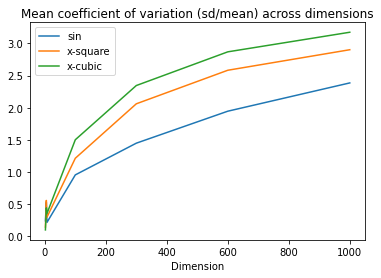

In [16]:
# the number of dims
dims = [2, 5, 7, 100, 300, 600, 1000] 
q = dist.Dirichlet
funcs = [
    lambda x: np.sin(x),
    lambda x: np.power(x, 2),
    lambda x: np.power(x, 3),
]

run_mc_experiment(dims, funcs, q, n_trials=20, 
                  n_samples=100, 
                  func_names=["sin", "x-square", "x-cubic"])

The converge rate of MC integral is $O(N^{-\frac{1}{D}})$ if we use $N$ particles in a $D$ dimensional space. 

**b) Simultaneous Parameter Update**

This is again linked to the high dimensionality of the latent variables. Since the number of parameters is proportionate to the number of latent variables, BBVI needs to update a large number of parameters in each step.

Since the high variance of the ELBO gradient is 

A potential issue is that to increment all $d$ parameters by Δ for example, we will need a vector (Δ, ..., Δ) $\in\mathbb{R}^d$. The norm of this vector is Δ$\sqrt{d}$ which can be quite large as $d$ grows with observations, so it will require a similarly large learning rate. This is fine if the gradient estimate is accurate. However, our gradient estimate is noisy and it is possible to take very large steps in a few dimensions. This results in instability in our parameters.